In [1]:
import gym
from torch import nn
import torch
import pandas as pd
from sklearn.model_selection import train_test_split, KFold
import matplotlib.pyplot as plt
import random
import numpy as np
import optuna
from sb3_contrib import TRPO
from gym import spaces
import os
from torch.utils.data import Dataset

# Make data

In [99]:
class ClipReward(gym.RewardWrapper):
    def __init__(self, env):
        super().__init__(env)

    def reward(self, reward):
        ram = env.unwrapped.ale.getRAM()
        reward = 0
        if 140 <= ram[106] <= 141:
            reward += 10000
        reward += (ram[14] * 1.5) - 90
        if 90 <= ram[106] <= 100:
            reward -= 1000
        return reward

class ObservationRAM(gym.ObservationWrapper):
    def __init__(self, env):
        super().__init__(env)
        self.observation_space = spaces.Box(low=0, high=210, shape=(13, ))

    def observation(self, obs):

        obs = obs[[14, 103, 106, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117]].astype(float)

        obs[0] /= 176
        obs[2] /= 142
        for i in range(3, 13):
            obs[i] /= 160

        return obs

In [104]:
def get_action_sample():
    x = random.randint(0, 101)
    if x < 90:
        return 1
    if x < 97:
        return 2
    return 0

def get_env_data(n):
    env_data = ClipReward(ObservationRAM(gym.make("ALE/Freeway-v5", obs_type="ram", render_mode="rgb_array", difficulty=1, mode=3)))
    observation = env_data.reset()
    df = pd.DataFrame(observation).T
    # Actions: 0: nichts, 1: up, 2: down
    actions = []

    for i in range(n):

        action = get_action_sample()
        if i != 0:
            df.loc[len(df)] = observation
        actions.append(action)
        print(action)
        observation, reward, done, info = env_data.step(action)
        if done:
            observation = env_data.reset()
        if i % (n / 100) == 0:
            print(f"{(i / n) * 100}%")
    env_data.close()
    df["actions"] = actions
    df = df.rename(columns={0: "y", 1: "score", 2: "cooldown",
                            3: "car1", 4: "car2", 5: "car3", 6: "car4", 7: "car5", 8: "car6", 9: "car7", 10: "car8", 11: "car9", 12: "car10"})

    return df

In [105]:
get_env_data(100)

1


AttributeError: 'CustomEnv' object has no attribute 'ale'

In [5]:
env = ClipReward(ObservationRAM(gym.make("ALE/Freeway-v5", obs_type="ram", render_mode="human", difficulty=1, mode=3)))
obs = env.reset()

for _ in range(2048):
    action = get_action_sample()
    observation, reward, done, info = env.step(action)
    print(observation)

[0.05681818 0.         0.         0.0375     0.01875    0.0125
 0.01875    0.0375     0.95625    0.975      0.9875     0.975
 0.95625   ]
[0.07954545 0.         0.         0.0875     0.04375    0.025
 0.04375    0.0875     0.90625    0.95       0.975      0.95
 0.90625   ]
[0.10227273 0.         0.         0.1375     0.06875    0.0375
 0.06875    0.1375     0.85625    0.925      0.9625     0.925
 0.85625   ]
[0.125   0.      0.      0.1875  0.09375 0.05    0.09375 0.1875  0.80625
 0.9     0.95    0.9     0.80625]
[0.03409091 0.         0.63380282 0.2375     0.11875    0.0625
 0.11875    0.2375     0.75625    0.875      0.9375     0.875
 0.75625   ]
[0.03409091 0.         0.61971831 0.2875     0.14375    0.075
 0.14375    0.2875     0.70625    0.85       0.925      0.85
 0.70625   ]
[0.03409091 0.         0.6056338  0.3375     0.16875    0.0875
 0.16875    0.3375     0.65625    0.825      0.9125     0.825
 0.65625   ]
[0.03409091 0.         0.5915493  0.3875     0.19375    0.1
 0.19375 

KeyboardInterrupt: 

# NN

In [51]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(14, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 13),
            nn.ReLU()
        )

    def forward(self, x):
        x = self.linear_relu_stack(x)
        #x = torch.FloatTensor(x)
        return x

In [7]:
def get_dfs(df):
    df = df.tail(len(df) - 1)

    dfY = df.copy()
    dfY.drop(["actions"], axis=1, inplace=True)

    dfY = dfY.drop(dfY.index[[0]])
    df = df.drop(df.index[[len(df) - 1]])
    dfY.index = df.index

    df = df.reset_index(drop=True)
    dfY = dfY.reset_index(drop=True)
    return df, dfY

In [43]:
def train(X, y, model, loss_fn, optimizer, batch_size):
    model.train()
    loss_sum = 0

    for i in range(round((len(y) / batch_size) + 0)):

        train_X = torch.from_numpy(X[i * batch_size:(i + 1) * batch_size]).cuda()
        train_y = torch.from_numpy(y[i * batch_size:(i + 1) * batch_size]).cuda()

        loss = 0

        for k in range(min(batch_size, len(train_X))):
            pred = model.forward(train_X[k].float())

            loss += loss_fn(pred.to(torch.float32), train_y[k].to(torch.float32))
        loss_sum += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    return loss_sum / len(y)


def test(X, y, model, loss_fn, batch_size):
    loss_sum = 0

    model.eval()
    with torch.no_grad():
        for i in range(round((len(y) / batch_size) + 1)):

            test_X = torch.from_numpy(X[i * batch_size:(i + 1) * batch_size]).cuda()
            test_y = torch.from_numpy(y[i * batch_size:(i + 1) * batch_size]).cuda()

            for k in range(min(batch_size, len(test_X))):
                pred = model.forward(test_X[k].float())
                loss = loss_fn(pred, test_y[k])
                loss_sum += loss.item()

    loss_sum /= len(y)

    print(f"Avg loss: {loss_sum}!")
    return loss_sum

In [46]:
def cv_model(X, y, batch_size, learning_rate):
    train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.3)

    model = Net().cuda()
    for layer in model.children():
        if hasattr(layer, "reset_parameters"):
            layer.reset_parameters()

    loss_fn = nn.L1Loss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    last_test_avg = 10000
    test_avg = 0

    overfit = 0

    epochs = 100

    train_loss = []
    test_loss = []

    '''
    train_X = torch.from_numpy(train_X.to_numpy()).cuda()
    test_X = torch.from_numpy(test_X.to_numpy()).cuda()
    train_y = torch.from_numpy(train_y.to_numpy()).cuda()
    test_y = torch.from_numpy(test_y.to_numpy()).cuda()
    '''

    train_X = train_X.to_numpy()
    test_X = test_X.to_numpy()
    train_y = train_y.to_numpy()
    test_y = test_y.to_numpy()


    test_loss.append(test(test_X, test_y, model, loss_fn, batch_size))

    for t in range(epochs):
        print(f"Epoch {t + 1}-----------------------------")
        train_l = train(train_X, train_y, model, loss_fn, optimizer, batch_size)
        train_loss.append(train_l)

        test_avg = test(test_X, test_y, model, loss_fn, batch_size)
        test_loss.append(test_avg)
        if test_avg > last_test_avg:
            overfit += 1
        else:
            overfit = 0
            last_test_avg = test_avg
        if overfit >= 10:
            print(f"Epoche: {t}")
            break
    return model
print("done")

done


In [73]:
%%time

n_data = 4096

df = get_env_data(n_data)
df, dfY = get_dfs(df)

train_all = []
test_all = []

model = TRPO("MlpPolicy", env, gamma=0.99, verbose=1)
model.save("trpo_models/tmp")

loss = 0

for i in range(1):
    _ = cv_model(df, dfY, learning_rate=0.0014009603189390793, batch_size=41)

    #train_all.append(train_loss)
    #test_all.append(test_loss)

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
0.0%


KeyboardInterrupt: 

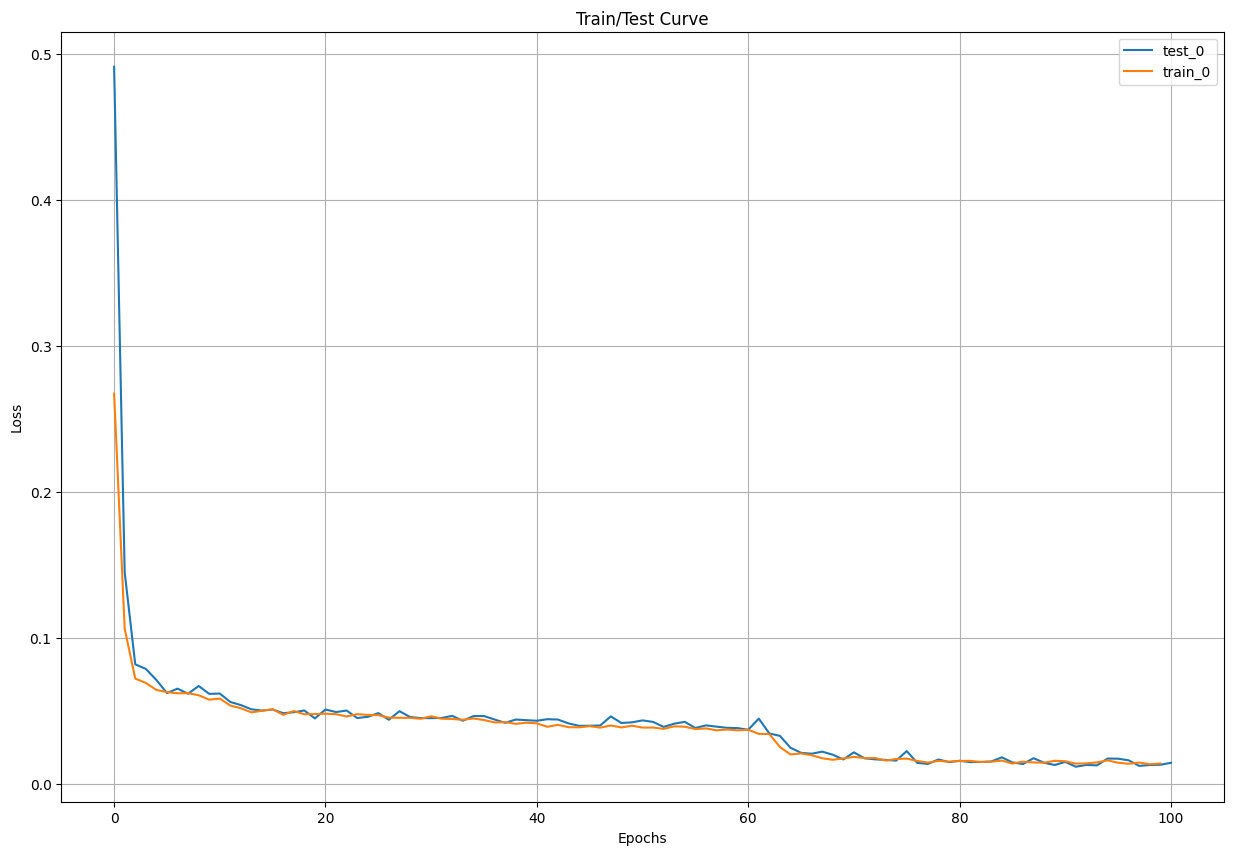

In [9]:
plt.figure(figsize=(15,10))
for count, i in enumerate(test_all):
    plt.plot(i, label=f"test_{count}")
for i in train_all:
    plt.plot(i, label=f"train_{count}")
plt.grid()
plt.legend()
plt.title("Train/Test Curve")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

# Test

In [75]:
class CustomEnv(gym.Env):
    def __init__(self, models):
        self.models = models
        self.GAME_START = [6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
        self.state = self.GAME_START.copy()
        self.score = 0
        self.observation_space = spaces.Box(low=0, high=210, shape=(13, ))
        self.action_space = spaces.Discrete(3)
        self.step_counter = 0
        self.done = False

    def step(self, action):
        self.state[0] /= 176
        self.state[2] /= 142
        for i in range(3, 13):
            self.state[i] /= 160
        self.done = False
        self.state.append(action)
        self.state = torch.tensor(self.state).cuda()
        self.state = self.models[np.random.randint(0, len(self.models))].forward(self.state.float())
        self.state = self.state.tolist()

        # Normalize
        # cars: 160
        # y: 176
        # cooldown: 142
        self.state[0] *= 176
        self.state[2] *= 142
        for i in range(3, 13):
            self.state[i] *= 160

        self.state = [round(i) for i in self.state]

        reward = 0
        reward += self.state[0]
        if self.state[0] == 0:
            self.state[0] += 0.1
        reward -= 1000/self.state[0]
        if 90 <= self.state[2] <= 100:
            reward -= 10000
        if self.state[1] - 0.5 > self.score:
            self.score = self.state
            reward += 10000
        self.step_counter += 1
        if self.step_counter % 2048 == 0:
            self.state = self.GAME_START.copy()
            self.done = True
        return self.state, reward, self.done, {}

    def reset(self):
        self.state = self.GAME_START.copy()
        self.score = 0
        return self.state

In [142]:
%%time
models = [torch.load("game_model/game_model_1").cuda()]

env = CustomEnv(models)
env.reset()

for i in range(10000):
    env.step(1)

CPU times: total: 6.95 s
Wall time: 6.98 s


# Custom Env Test

In [135]:
%%time


ITERATIONS = 50
STEPS_PER_ITERATION = 2048

env = CustomEnv(models)

trpo = TRPO("MlpPolicy", env, gamma=0.99, verbose=1)
trpo.learn(total_timesteps=ITERATIONS*STEPS_PER_ITERATION, log_interval=5)

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
-----------------------------------------
| rollout/                  |           |
|    ep_len_mean            | 2.05e+03  |
|    ep_rew_mean            | -4.41e+04 |
| time/                     |           |
|    fps                    | 496       |
|    iterations             | 5         |
|    time_elapsed           | 20        |
|    total_timesteps        | 10240     |
| train/                    |           |
|    explained_variance     | 0.000934  |
|    is_line_search_success | 1         |
|    kl_divergence_loss     | 0.00242   |
|    learning_rate          | 0.001     |
|    n_updates              | 4         |
|    policy_objective       | 0.00814   |
|    value_loss             | 4.03e+08  |
-----------------------------------------
-----------------------------------------
| rollout/                  |           |
|    ep_len_mean            | 2.05e+03  |
|    ep_rew_mean       

# Train ME-TRPO

In [85]:
N_DATA = 4096
N_MODELS = 1
ITERATIONS_PER_EPOCH = 100
STEPS_PER_ITERATION = 2048
EPOCHS = 5
model_counter = 0
trpo = TRPO("MlpPolicy", ClipReward(ObservationRAM(gym.make("ALE/Freeway-v5", obs_type="ram", render_mode="rgb_array", difficulty=1, mode=3))), gamma=0.99, verbose=1)

def make_models(n):
    global model_counter
    df = get_env_data(n_data)

    df.to_csv(f"gamedata/data_{model_counter}")
    if model_counter > 0:
        df = pd.concat([pd.read_csv(f"gamedata/data_{j}") for j in range(model_counter + 1)])
    model_counter += 1
    df, dfY = get_dfs(df)

    models = []

    for i in range(n):
        models.append(cv_model(df, dfY, learning_rate=0.0014009603189390793, batch_size=41))
    return models

for i in range(EPOCHS):
    models = make_models(N_MODELS)
    env = CustomEnv(models)

    trpo.learn(total_timesteps=ITERATIONS_PER_EPOCH*STEPS_PER_ITERATION, log_interval=5)
    trpo.save(f"trpo_models/tmp")

trpo.save(f"trpo_models/model_1")

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
0.0%


OverflowError: cannot convert float infinity to integer

In [175]:
env = ClipReward(ObservationRAM(gym.make("ALE/Freeway-v5", obs_type="ram", render_mode="human", difficulty=1, mode=3)))
model = TRPO.load("trpo_models/n_models_2/epoche_0")

obs = env.reset()
for _ in range(2048):
    action, _states = model.predict(obs, deterministic=True)
    obs, reward, done, info = env.step(action)
    #env.render()
    #time.sleep(0.00001)
    print(reward)
    if done:
        obs = env.reset()

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
-76.5
<class 'numpy.ndarray'>
-81.0
<class 'numpy.ndarray'>
-81.0
<class 'numpy.ndarray'>
-81.0
<class 'numpy.ndarray'>
-81.0
<class 'numpy.ndarray'>
-81.0
<class 'numpy.ndarray'>
-81.0
<class 'numpy.ndarray'>
-81.0
<class 'numpy.ndarray'>
-81.0
<class 'numpy.ndarray'>
-81.0
<class 'numpy.ndarray'>
-81.0
<class 'numpy.ndarray'>
-81.0
<class 'numpy.ndarray'>
-81.0
<class 'numpy.ndarray'>
-81.0
<class 'numpy.ndarray'>
-81.0
<class 'numpy.ndarray'>
-81.0
<class 'numpy.ndarray'>
-81.0
<class 'numpy.ndarray'>
-81.0
<class 'numpy.ndarray'>
-81.0
<class 'numpy.ndarray'>
-81.0
<class 'numpy.ndarray'>
-81.0
<class 'numpy.ndarray'>
-75.0
<class 'numpy.ndarray'>
-69.0
<class 'numpy.ndarray'>
-63.0
<class 'numpy.ndarray'>
-1081.0
<class 'numpy.ndarray'>
-81.0
<class 'numpy.ndarray'>
-81.0
<class 'numpy.ndarray'>
-81.0
<class 'numpy.ndarray'>
-81.0
<class 'numpy.ndarray'>
-81.0
<class 'numpy.ndarray'>
-81.0
<class 'numpy.ndarray'>
-81.0
<class 'numpy.

KeyboardInterrupt: 